# Data Overview

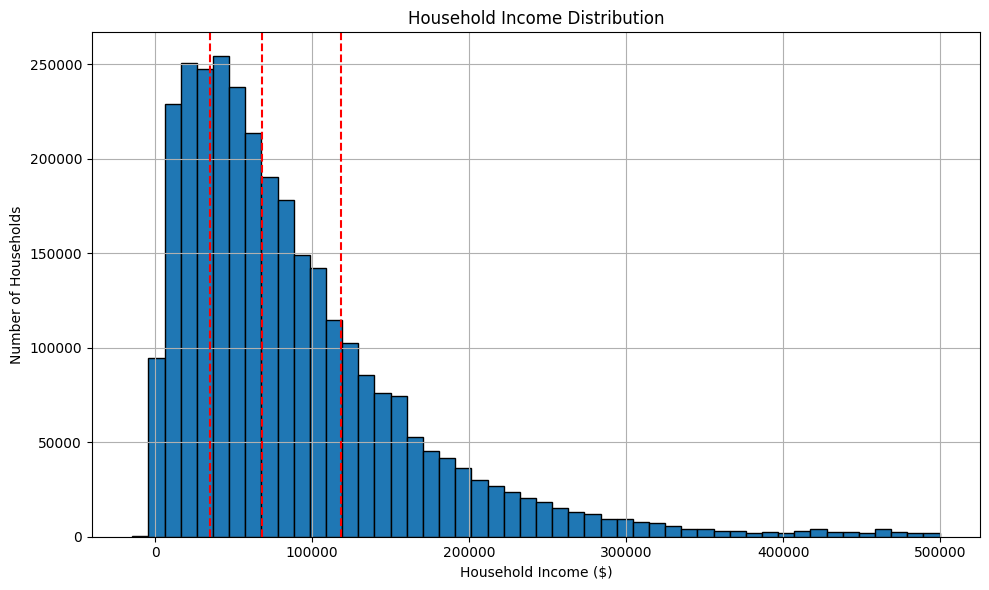

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load household file
household_df = pd.read_csv('va_household.csv')

# Drop missing or extreme values if needed
income = household_df['hh_income'].dropna()
income = income[income < 500000]  # optional upper cap to remove outliers

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(income, bins=50, edgecolor='black')
for q in [0.25, 0.5, 0.75]:
    plt.axvline(income.quantile(q), color='red', linestyle='--', label=f'{int(q*100)}th percentile')
plt.title("Household Income Distribution")
plt.xlabel("Household Income ($)")
plt.ylabel("Number of Households")
plt.grid(True)
plt.tight_layout()
plt.show()


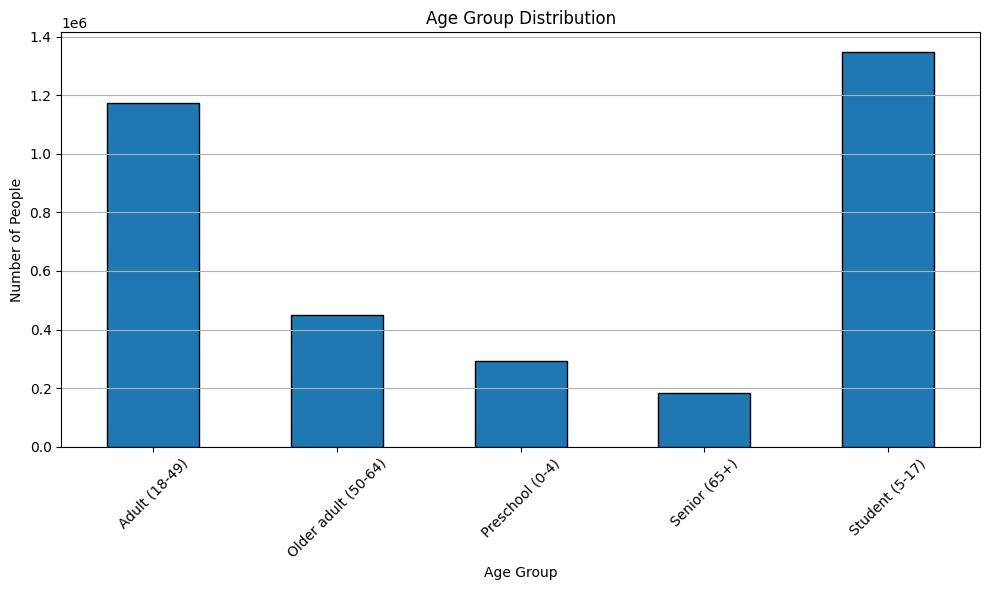

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
infection_df = pd.read_csv('run_03_vadelta_rate_limited_ticks.metadata.fixed_dates.tsv', sep="\t", skiprows=[1])

# Count by age group
age_counts = infection_df['age_group'].value_counts().sort_index()

# Plot
plt.figure(figsize=(10, 6))
age_counts.plot(kind='bar', edgecolor='black')
plt.title("Age Group Distribution")
plt.xlabel("Age Group")
plt.ylabel("Number of People")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


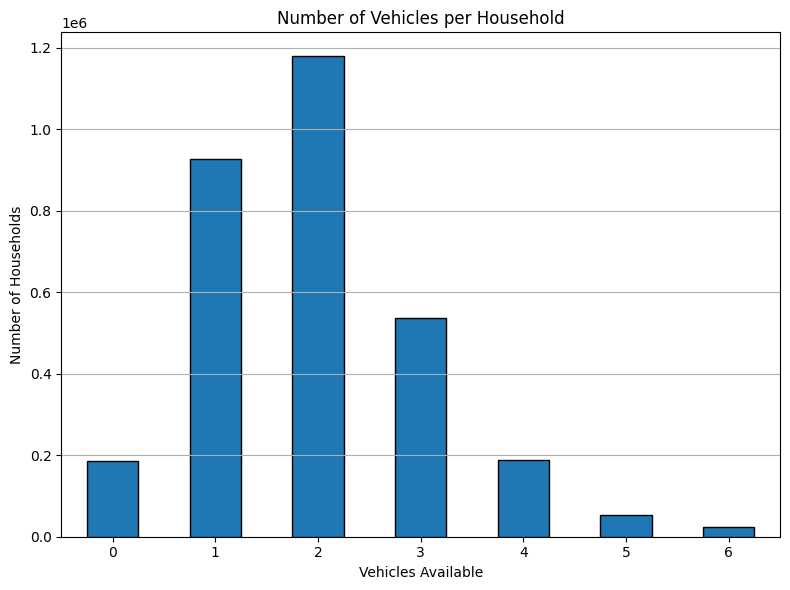

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
household_df = pd.read_csv("va_household.csv")

# Clean the vehicles column
vehicle_counts = household_df['vehicles'].dropna().astype(int)

# Count number of households by vehicle count
vehicle_distribution = vehicle_counts.value_counts().sort_index()

# Plot
plt.figure(figsize=(8, 6))
vehicle_distribution.plot(kind='bar', edgecolor='black')
plt.title("Number of Vehicles per Household")
plt.xlabel("Vehicles Available")
plt.ylabel("Number of Households")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


# LineList Construction

In [1]:
import pandas as pd
import numpy as np

# Load data
people_df = pd.read_csv('va_persontrait_epihiper.txt', sep=",", skiprows=1)
infection_df = pd.read_csv('run_03_vadelta_rate_limited_ticks.metadata.fixed_dates.tsv', sep="\t", skiprows=[1])  # contains pid, hid, ...
household_df = pd.read_csv('va_household.csv')  # contains hid, hh_income, etc.

people_df = people_df.rename(columns={'pid': 'sim_pid'})
infection_df = infection_df.merge(people_df[['sim_pid', 'county_fips']], on='sim_pid', how='left')
infection_df = infection_df.merge(people_df[['sim_pid', 'hid']], on='sim_pid', how='left')
infection_df = infection_df.merge(people_df[['sim_pid', 'occupation_socp']], on='sim_pid', how='left')

# Load RUCC lookup
rucc_long = pd.read_csv("Ruralurbancontinuumcodes2023.csv",encoding="latin1")

# Pivot to wide format
rucc_wide = rucc_long.pivot_table(
    index=["FIPS", "State", "County_Name"],
    columns="Attribute",
    values="Value",
    aggfunc='first'
).reset_index()

# Rename for clarity
rucc_wide = rucc_wide.rename(columns={"RUCC_2023": "rucc_code"})
rucc_wide['rucc_code'] = pd.to_numeric(rucc_wide['rucc_code'], errors='coerce')

# Ensure both are string with 5-digit format
infection_df['county_fips'] = infection_df['county_fips'].astype(str).str.zfill(5)
rucc_wide['FIPS'] = rucc_wide['FIPS'].astype(str).str.zfill(5)

# Merge RUCC code into people
infection_df = infection_df.merge(
    rucc_wide[['FIPS', 'rucc_code']],
    left_on='county_fips',
    right_on='FIPS',
    how='left'
)

# Merge on household ID
df = infection_df.merge(household_df, on='hid', how='left')
df["age_group"] = (
    df["age_group"]
      .str.replace(r"[–—−]", "-", regex=True)   # en/em/minus → ASCII hyphen
      .str.strip()                              # trim spaces
)

In [2]:
import numpy as np
import pandas as pd

# Randomly assign 'asymptomatic' to 35% of the rows in the entire DataFrame
df['asymptomatic'] = np.random.rand(len(df)) < 0.35

print(df)

        virus         region country  division divisionExposure        date  \
0        ncov  North America     USA  Virginia         Virginia  2021-04-07   
1        ncov  North America     USA  Virginia         Virginia  2021-04-12   
2        ncov  North America     USA  Virginia         Virginia  2021-04-12   
3        ncov  North America     USA  Virginia         Virginia  2021-04-12   
4        ncov  North America     USA  Virginia         Virginia  2021-04-15   
...       ...            ...     ...       ...              ...         ...   
3444980  ncov  North America     USA  Virginia         Virginia  2021-10-03   
3444981  ncov  North America     USA  Virginia         Virginia  2021-10-03   
3444982  ncov  North America     USA  Virginia         Virginia  2021-10-03   
3444983  ncov  North America     USA  Virginia         Virginia  2021-10-03   
3444984  ncov  North America     USA  Virginia         Virginia  2021-10-03   

                                 strain      sim_pi

In [32]:
print(df['asymptomatic'].value_counts(normalize=True))


asymptomatic
False    0.650448
True     0.349552
Name: proportion, dtype: float64


In [33]:
summary = pd.DataFrame({
    "none_count": (df == 'none').sum(),
    "nan_count": df.isna().sum()
})
print(summary)


                                   none_count  nan_count
virus                                       0          0
region                                      0          0
country                                     0          0
division                                    0          0
divisionExposure                            0          0
date                                        0          0
strain                                      0          0
sim_pid                                     0          0
sim_tick                                    0          0
sex                                         0          0
county                                      0          0
latitude                                    0    3444985
longitude                                   0    3444985
latino                                      0          0
race                                        0          0
smh_race                                    0          0
age_group                      

In [3]:
def compute_testing_probability(row):
    p = 0.5  # baseline

    # Income-based bias
    if pd.notnull(row['hh_income']):
        if row['hh_income'] < 40000:
            p *= 0.6
        elif row['hh_income'] < 70000:
            p *= 0.8
        elif row['hh_income'] < 110000:
            p *= 1.0
        else:
            p*=1.2

    # Age group
    if row['age_group'] == 'Preschool (0-4)':
        p *= 0.5
    elif row['age_group'] == 'Student (5-17)':
        p *= 0.7
    elif row['age_group'] == 'Adult (18-49)':
        p *= 1.0
    elif row['age_group'] == 'Older adult (50-64)':
        p *= 1.2
    elif row['age_group'] == 'Senior (65+)':
        p *= 1.4
    else:
        print("miss for age_group")

    # Race group
    race = row['smh_race']
    if race == 'White':
        p *= 1.0
    elif race == 'Asian':
        p *= 0.85
    elif race == 'Black':
        p *= 0.8
    elif race == 'Latino':
        p *= 0.75
    elif race == 'Other':
        p *= 0.7
    else:
        print("miss for smh_race")

    # Occupation: higher testing for essential
    soc_code = str(row['occupation_socp'])
    # Extract SOC major group (first 2 digits)
    major_group = soc_code[:2]
    # Only apply to working age
    if row['age_group'] == 'Adult (18–49)' or row['age_group'] == 'Older adult (50–64)':
        if major_group == '29':       # Healthcare
            p *= 1.4
        elif major_group == '35':     # Food service
            p *= 1.1
        elif major_group == '25':     # Education
            p *= 1.2
        elif major_group in ['11', '13']:  # Management, business
            p *= 1.0
        elif major_group in ['41', '53']:  # Sales, transport
            p *= 0.9
        elif major_group == '51':     # Manufacturing / production
            p *= 0.85
        else:
            p *= 0.7  # No job

    # Vehicles available (proxy for mobility/access)
    v = int(row['vehicles'])
    if v == 0:
        p *= 0.7
    elif v == 1:
        p *= 0.9
    else:  # 2 or more
        p *= 1.0

    # Live in rural/city
    rucc = row['rucc_code']
    if rucc <= 3:
        p *= 1.0  # metro
    elif rucc <= 6:
        p *= 0.85  # suburban/small city
    else:
        p *= 0.7  # rural

    # Symptoms: asymptomatic people are less likely to test
    if row['asymptomatic'] == True:
        p *= 0  # dont go to test
    elif row['asymptomatic'] == False:
        p *= 1  # go to test based on other prob


    return min(max(p, 0), 1)

In [4]:
# Compute testing probabilities
df['test_prob'] = df.apply(compute_testing_probability, axis=1)

# Simulate who came to test
df['tested_positive'] = np.random.binomial(1, df['test_prob'])

# Final linelist
linelist_df = df[df['tested_positive'] == 1].copy()

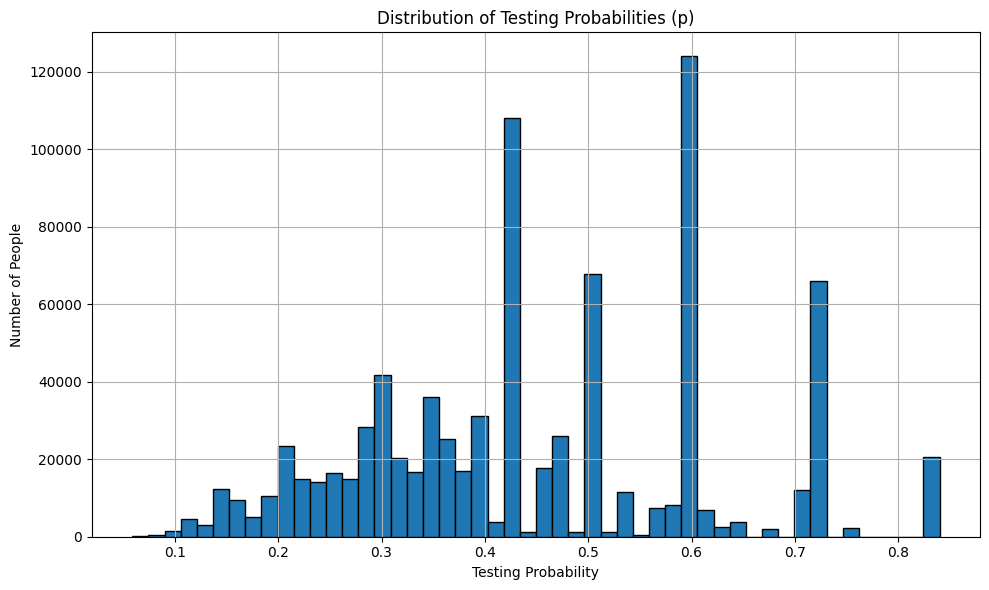

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(linelist_df['test_prob'], bins=50, edgecolor='black')
plt.title("Distribution of Testing Probabilities (p)")
plt.xlabel("Testing Probability")
plt.ylabel("Number of People")
plt.grid(True)
plt.tight_layout()
plt.show()


In [6]:
linelist_df.to_csv('simulated_test_positive_linelist.csv', index=False)

In [42]:
linelist_df.count()

virus                                842419
region                               842419
country                              842419
division                             842419
divisionExposure                     842419
date                                 842419
strain                               842419
sim_pid                              842419
sim_tick                             842419
sex                                  842419
county                               842419
latitude                                  0
longitude                                 0
latino                               842419
race                                 842419
smh_race                             842419
age_group                            842419
county_fips                          842419
hid                                  842419
occupation_socp                      492586
FIPS                                 842419
rucc_code                            842419
admin1                          

In [43]:
people_df.count()

sim_pid            7684795
hid                7684795
age                7684795
age_group          7684795
gender             7684795
county_fips        7684795
race               7684795
hispanic           7684795
smh_race           7684795
occupation_socp    4756205
designation        7684795
age_label          7684795
dtype: int64

In [44]:
infection_df.count()

virus               3444985
region              3444985
country             3444985
division            3444985
divisionExposure    3444985
date                3444985
strain              3444985
sim_pid             3444985
sim_tick            3444985
sex                 3444985
county              3444985
latitude                  0
longitude                 0
latino              3444985
race                3444985
smh_race            3444985
age_group           3444985
county_fips         3444985
hid                 3444985
occupation_socp     1632749
FIPS                3444985
rucc_code           3444985
age_label                 0
dtype: int64

# Result Comparison

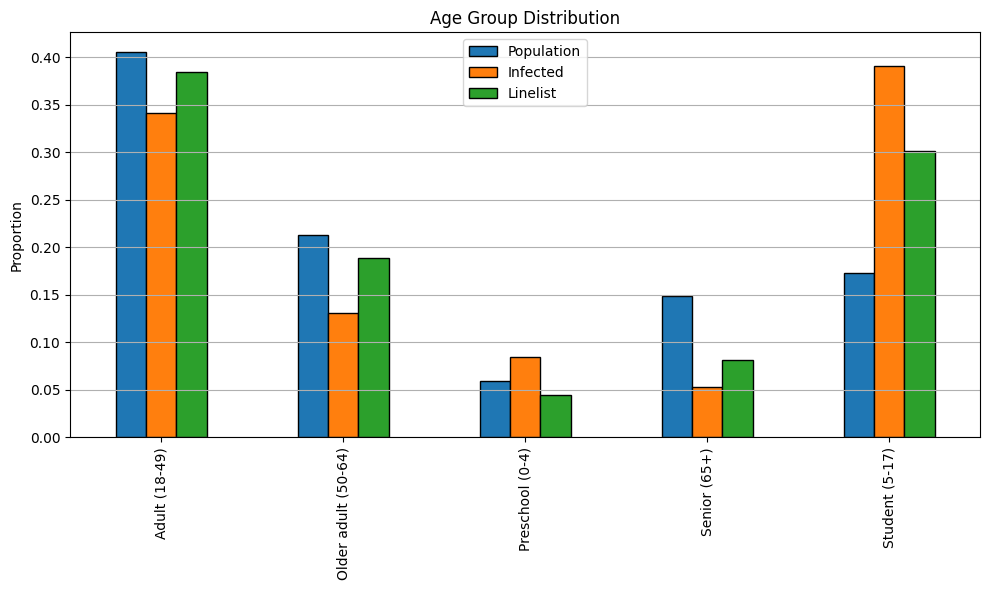

In [41]:
import matplotlib.pyplot as plt

# Map age group codes to labels
age_map = {
    "p": "Preschool (0-4)",
    "s": "Student (5-17)",
    "a": "Adult (18-49)",
    "o": "Older adult (50-64)",
    "g": "Senior (65+)"
}
people_df['age_label'] = people_df['age_group'].map(age_map)

# Count per age group in population vs. linelist
pop_age = people_df['age_label'].value_counts(normalize=True).sort_index()
line_age = linelist_df['age_group'].value_counts(normalize=True).sort_index()
infection_age = infection_df['age_group'].value_counts(normalize=True).sort_index()

# Combine into a DataFrame
age_comp = pd.DataFrame({'Population': pop_age, 'Infected':infection_age, 'Linelist': line_age})

# Plot
age_comp.plot(kind='bar', figsize=(10, 6), edgecolor='black')
plt.title("Age Group Distribution")
plt.ylabel("Proportion")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


<Axes: title={'center': 'Race Distribution'}>

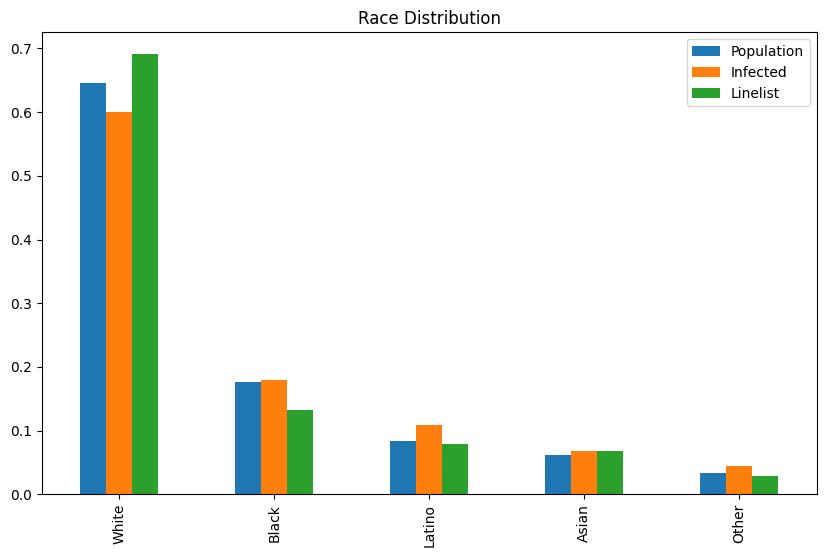

In [46]:
people_df["smh_race_label"] = people_df["smh_race"].astype(str).map({
    "W": "White", "B": "Black",
    "L": "Latino", "A": "Asian",
    "O": "Other"
})

race_comp = pd.DataFrame({
    'Population': people_df['smh_race_label'].value_counts(normalize=True),
    'Infected': infection_df['smh_race'].value_counts(normalize=True),
    'Linelist': linelist_df['smh_race'].value_counts(normalize=True)
})
race_comp.plot(kind='bar', title="Race Distribution", figsize=(10, 6))


In [ ]:
people_df = people_df.merge(household_df, on='hid', how='left')
infection_df = infection_df.merge(household_df, on='hid', how='left')

# Bin income into groups
bins = [0, 40000, 70000, 110000, float('inf')]
labels = ['Low', 'Lower-mid', 'Upper-mid', 'High']

people_df['income_bin'] = pd.cut(people_df['hh_income'], bins=bins, labels=labels)
linelist_df['income_bin'] = pd.cut(linelist_df['hh_income'], bins=bins, labels=labels)
infection_df['income_bin'] = pd.cut(infection_df['hh_income'], bins=bins, labels=labels)

income_comp = pd.DataFrame({
    'Population': people_df['income_bin'].value_counts(normalize=True),
    'Infected': infection_df['income_bin'].value_counts(normalize=True),
    'Linelist': linelist_df['income_bin'].value_counts(normalize=True)
})
income_comp.plot(kind='bar', title="Income Distribution", figsize=(10, 6))


KeyError: 'hh_income'

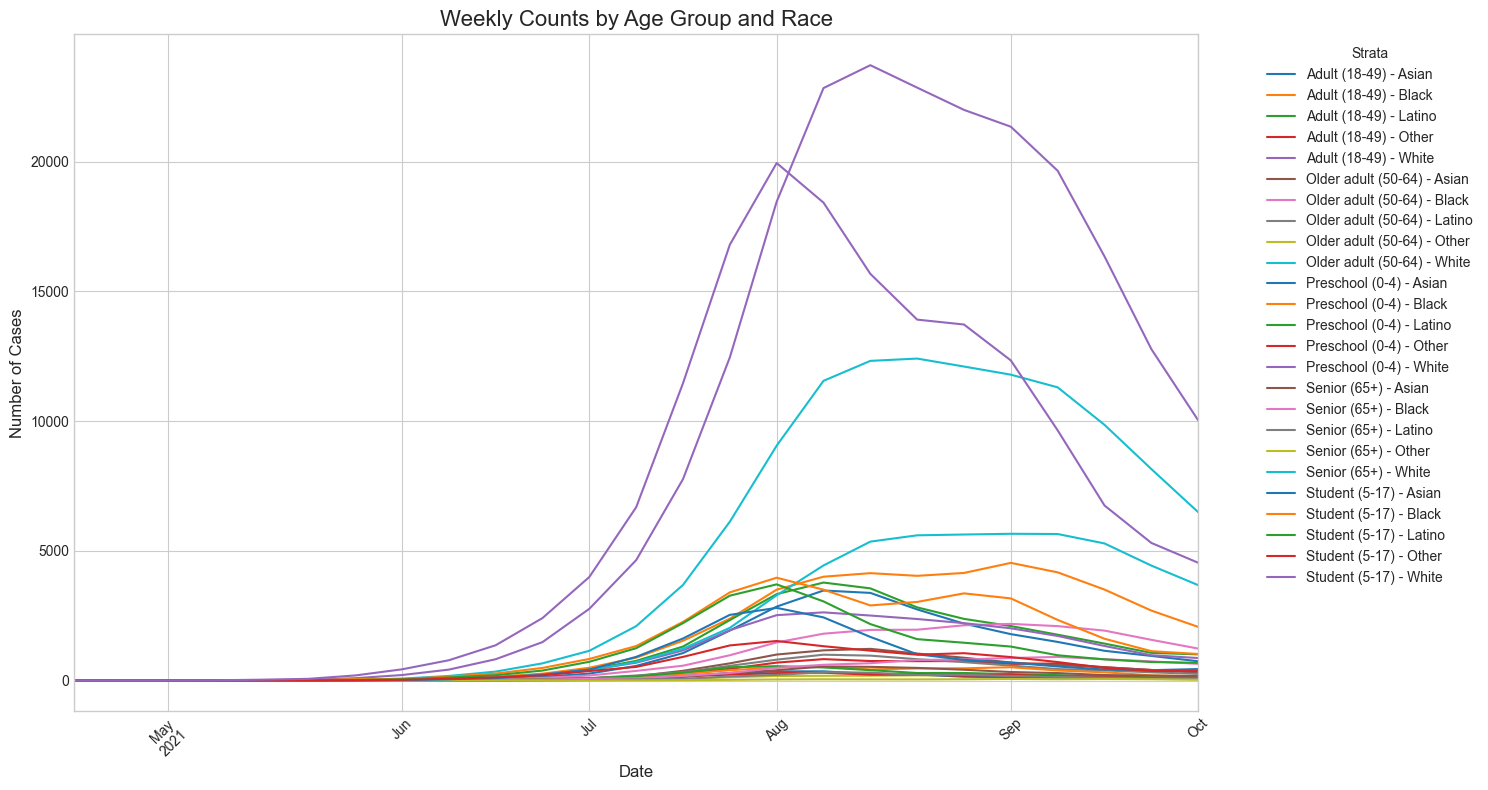

In [57]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Load Your Data ---
# Replace 'your_line_list_file.csv' with the actual name of your file.
# Replace 'date_column_name' with the name of the date column in your file.
LINE_LIST_FILE = "simulated_test_positive_linelist.csv"
DATE_FIELD = "date"

# Load the data from your local file
# This assumes your file is a CSV. If not, use the appropriate pandas function (e.g., pd.read_excel).
line_df = pd.read_csv(LINE_LIST_FILE, parse_dates=[DATE_FIELD])

# --- Preprocessing and Plotting ---
# Ensure column names 'age_group' and 'smh_race' match your dataframe.
# If your column names are different, please update them in the code below.

# Combine 'age_group' and 'smh_race' to create strata
line_df['strata'] = line_df['age_group'] + ' - ' + line_df['smh_race']

# Set the date column as the index
line_df = line_df.set_index(DATE_FIELD)

# Resample by week and count occurrences for each stratum
# You can change 'W' to 'D' for daily, 'M' for monthly, etc.
strata_counts = line_df.groupby('strata').resample('W').size().unstack(level=0, fill_value=0)

# --- Generate the Plot ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(15, 8))

# Plot the data
strata_counts.plot(ax=ax)

# Format the plot
ax.set_title('Weekly Counts by Age Group and Race', fontsize=16)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Number of Cases', fontsize=12)
ax.legend(title='Strata', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()

# To save the plot to a file, uncomment the line below
# plt.savefig('strata_plot.png')

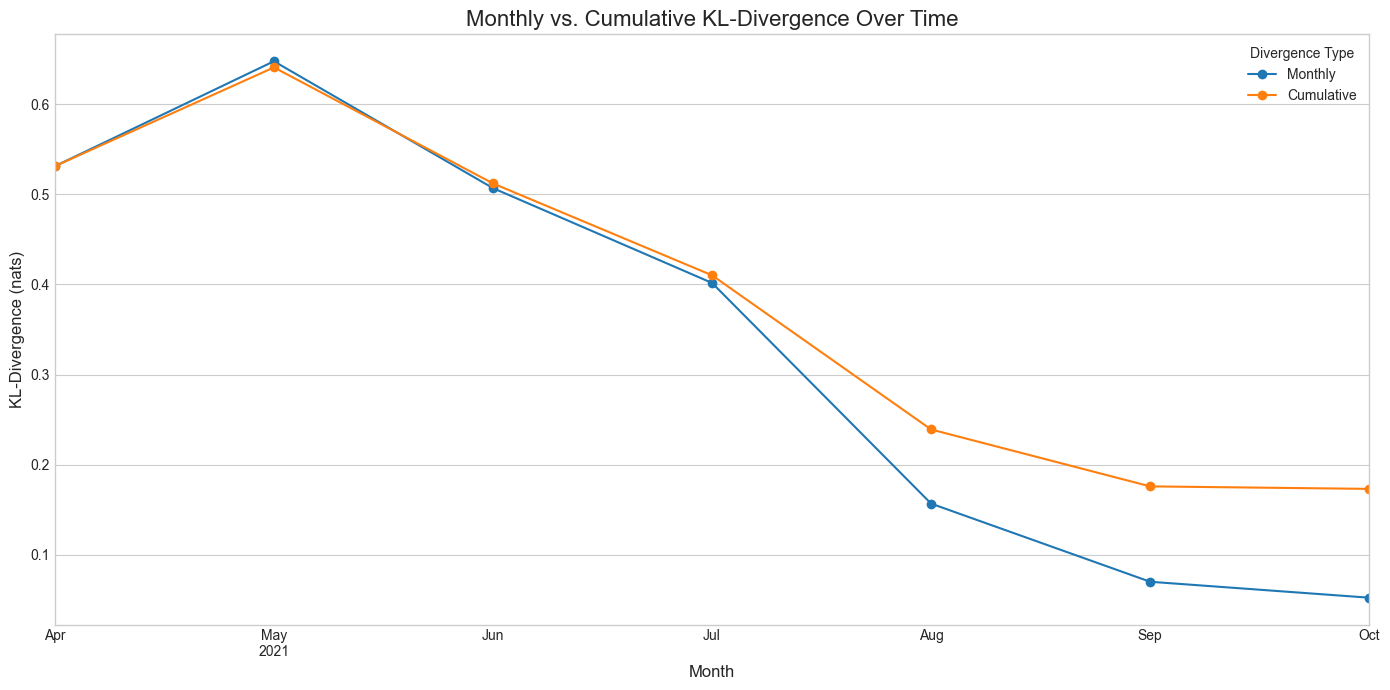

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import kl_div

# --- 1. Load Your Data ---
# Replace with your actual file paths and column names.
LINE_LIST_FILE = "run_03_vadelta_rate_limited_ticks.metadata.fixed_dates.tsv"
POPULATION_FILE = "va_persontrait_epihiper.txt"
DATE_FIELD = "date"

#line_df = pd.read_csv(LINE_LIST_FILE, parse_dates=[DATE_FIELD])
line_df = pd.read_csv(LINE_LIST_FILE, sep="\t", skiprows=[1])
pop_df = pd.read_csv(POPULATION_FILE, skiprows=1)
pop_df["age_group"] = pop_df["age_group"].map({"p": "Preschool (0-4)", "s": "Student (5-17)", "a": "Adult (18-49)", "o": "Older adult (50-64)", "g": "Senior (65+)"})
pop_df = pop_df.rename(columns={"gender": "sex"})
pop_df["sex"] = pop_df["sex"].astype(str).map({"1": "male", "2": "female"})
pop_df["smh_race"] = pop_df["smh_race"].astype(str).map({"W": "White", "B": "Black", "L": "Latino", "A": "Asian", "O": "Other"})

# --- 2. Prepare Data ---
# Ensure your column names for strata are correct.
pop_df['group'] = pop_df['age_group'] + ' - ' + pop_df['smh_race']
line_df['group'] = line_df['age_group'] + ' - ' + line_df['smh_race']


# --- 3. Calculate KL-Divergence Over Time ---

# P: The static reference distribution (population)
pop_dist = pop_df['group'].value_counts(normalize=True)

# Get a sorted list of unique months in the data
line_df[DATE_FIELD] = pd.to_datetime(line_df[DATE_FIELD])
months = sorted(line_df[DATE_FIELD].dt.to_period('M').unique())

monthly_kl = {}
cumulative_kl = {}

# Define a small epsilon for stability
epsilon = 1e-9

for month in months:
    # --- Monthly Calculation ---
    monthly_data = line_df[line_df[DATE_FIELD].dt.to_period('M') == month]
    if not monthly_data.empty:
        q_monthly = monthly_data['group'].value_counts(normalize=True)
        all_strata = pop_dist.index.union(q_monthly.index)
        
        p_aligned = pop_dist.reindex(all_strata, fill_value=epsilon)
        q_aligned_monthly = q_monthly.reindex(all_strata, fill_value=epsilon)
        
        # Normalize to ensure they sum to 1
        p_aligned /= p_aligned.sum()
        q_aligned_monthly /= q_aligned_monthly.sum()

        monthly_kl[month.to_timestamp()] = kl_div(q_aligned_monthly, p_aligned).sum()

    # --- Cumulative Calculation ---
    cumulative_data = line_df[line_df[DATE_FIELD] <= month.to_timestamp(how='end')]
    if not cumulative_data.empty:
        q_cumulative = cumulative_data['group'].value_counts(normalize=True)
        all_strata = pop_dist.index.union(q_cumulative.index)

        p_aligned = pop_dist.reindex(all_strata, fill_value=epsilon)
        q_aligned_cumulative = q_cumulative.reindex(all_strata, fill_value=epsilon)

        # Normalize
        p_aligned /= p_aligned.sum()
        q_aligned_cumulative /= q_aligned_cumulative.sum()

        cumulative_kl[month.to_timestamp()] = kl_div(q_aligned_cumulative, p_aligned).sum()

# Convert results to a DataFrame for plotting
kl_df = pd.DataFrame({
    'Monthly': pd.Series(monthly_kl),
    'Cumulative': pd.Series(cumulative_kl)
})

# --- 4. Plot the Results ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(14, 7))

kl_df.plot(ax=ax, marker='o', linestyle='-')

# Formatting the plot
ax.set_title('Monthly vs. Cumulative KL-Divergence Over Time', fontsize=16)
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('KL-Divergence (nats)', fontsize=12)
ax.legend(title='Divergence Type')
ax.grid(True)
plt.tight_layout()

# Display the plot
plt.show()